In [1]:
import keras
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import models
from keras.utils import to_categorical
from keras.datasets import mnist

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


### Loading the MNIST Data


[The MNIST Database](http://yann.lecun.com/exdb/mnist/)

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

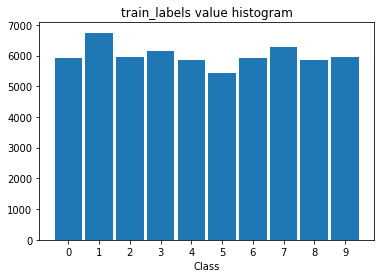

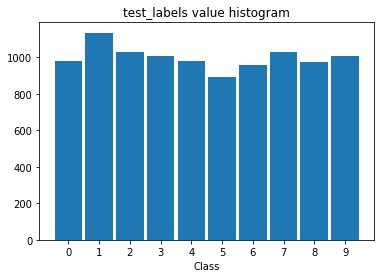

In [3]:
plt.hist(train_labels, bins=range(11), rwidth=.9, align='left')
plt.xticks(range(10))
plt.title('train_labels value histogram')
plt.xlabel('Class')
plt.show()

plt.hist(test_labels, bins=range(11), rwidth=.9, align='left')
plt.xticks(range(10))
plt.title('test_labels value histogram')
plt.xlabel('Class')
plt.show()

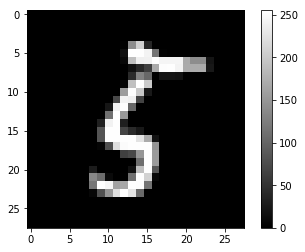

The image label is 5


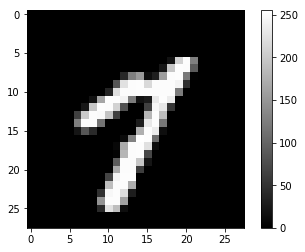

The image label is 7


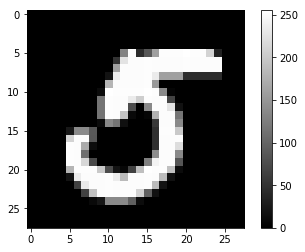

The image label is 5


In [4]:
for i in range(3):
    idx = random.randrange(test_images.shape[0])
    plt.imshow(test_images[idx], cmap='gray')
    plt.colorbar()
    plt.show()
    print('The image label is {}'.format(test_labels[idx]))

In [5]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Creating a Convolutional Neural Network Model

This is what a basic convnet looks like. It is a stack of Conv2D and MaxPooling2D layers.

The convnet takes input tensors of this shape:

- image_height (rows)

- image_width (columns)

- image_channels (color channels)



In this case, we'll configure the convnet to process inputs of size (28, 28, 1), which is the format of MNIST images.

The convolutional layers extract elementary features of the images. These layers use the typical 3 x 3 filter size.

In [6]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', \
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


After the last Conv2D layer the 3D feature array is flattened to 1D vector, which is then connected to dense layers. The purpose of the dense layers is to use the elementary image feature information from convolutional layers and combine individual features so that it can perform the classification task.

The activation functions on the Dense layers are ReLU and Softmax.

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

### Network-Compilation Step

categorical_crossentropy is the loss function that is used as a feedback signal for learning the weight tensors. The training phase will attempt to minimize the loss. This reduction of the loss happens via mini-batch stochastic gradient descent.

The rules governing a specific use of gradient descent are defined by the rmsprop optimizer passed as the first argument.

In [10]:
model.compile(optimizer='rmsprop',\
             loss='categorical_crossentropy',\
             metrics=['accuracy'])

### Training Loop

Each iteration over all the training data is called an epoch.

The network will start to iterate on the training data in mini-batches of 64 samples, 5 times over.

At each iteration, the network will compute the gradients of the weights with regard to the loss on the batch, and update the weights accordingly.

In [ ]:
fit = model.fit(train_images, train_labels, epochs=5, batch_size=64,\
                validation_data=(test_images, test_labels))

### Test Accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

test_acc

In [ ]:
plt.plot(fit.history['acc'])
plt.plot(fit.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [ ]:
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()